In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/opt/miniconda3/envs/torchtf/lib/python38.zip', '/opt/miniconda3/envs/torchtf/lib/python3.8', '/opt/miniconda3/envs/torchtf/lib/python3.8/lib-dynload', '', '/opt/miniconda3/envs/torchtf/lib/python3.8/site-packages', '/opt/miniconda3/envs/torchtf/lib/python3.8/site-packages/setuptools/_vendor', '../']


In [8]:
import torch
import torch.nn.functional as F
from networks.resnet_big import CEResNet
from networks.vision_trans import CEViT
from dataset import CANDataset #Using v2 if not include Timestamp
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from util import TwoCropTransform, AverageMeter, AddGaussianNoise
from torch.utils.data import DataLoader

In [4]:
seed = 1
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
device = torch.device("mps")

In [5]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [6]:
# # Not include Timestamp
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# train_dataset = CANDataset(root_dir='../data/Car-Hacking/all_features/v2/TFRecord_w32_s32/2', window_size=32, is_train=True,
#                     transform=TwoCropTransform(can_transform))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [12]:
test_dataset = CANDataset(root_dir='../data/can-ml/preprocessed/all_features/TFRecord_w32_s16/2', window_size=32, is_train=False)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [13]:
# model = CEResNet(num_classes=10)
model = CEViT(emb_size=256, n_classes=10)

save_path = '../save/CAN-ML_models/UniCon/UniCon_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_128_temp_0.07_mixup_lambda_0.5_trial_can-vit-v2_cosine_warm'
# /Users/hieutran/lab/unicon-ids/save/CAN-ML_models/UniCon/UniCon_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_128_temp_0.07_mixup_lambda_0.5_trial_can-vit-v2_cosine_warm


# save_path = '../save/CAN-ML_models/CE/CE_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_128_trial_can_ml_cosine_augment_warm'
# /Users/hieutran/lab/unicon-ids/save/CAN-ML_models/CE/CE_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_128_trial_can_ml_cosine_augment_warm/ckpt_epoch_26.pth
# ckpt_epoch = 16
ckpt_epoch = 100

model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)


<All keys matched successfully>

In [14]:
import numpy as np
import tqdm
import torch
from sklearn.metrics import accuracy_score, classification_report

total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)

model = model.to(device)
model.eval()

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.to(device, non_blocking=True)
        
        outputs = model(images)
        
        _, pred = torch.max(outputs, 1)
        
        pred = pred.cpu().numpy()
        labels = labels.cpu().numpy()
        
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)




100%|██████████| 205/205 [00:26<00:00,  7.83it/s]


In [15]:
accuracy = accuracy_score(total_label, total_pred) 
print("Accuracy:", accuracy)

target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(total_label, total_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

Accuracy: 0.9749752040894178
Classification Report:
               precision    recall  f1-score   support

      Normal     0.9808    0.9921    0.9864     22161
    Combined     0.9254    0.8895    0.9071      1186
         DoS     0.9896    0.9502    0.9695       201
       Fuzzy     0.9624    0.8836    0.9213       232
        Gear     0.9011    0.6721    0.7700       122
    Interval     0.9663    0.9412    0.9536      1157
         RPM     0.9046    0.7812    0.8384       352
       Speed     0.8949    0.8405    0.8668       395
  Standstill     0.9756    0.8743    0.9222       183
  Systematic     0.9388    0.8178    0.8741       225

    accuracy                         0.9750     26214
   macro avg     0.9440    0.8643    0.9010     26214
weighted avg     0.9745    0.9750    0.9745     26214



In [16]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [17]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (14 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [18]:
classes = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
n_classes = len(classes)

In [19]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal       | Combined     | DoS          | Fuzzy        | Gear         | Interval     | RPM          | Speed        | Standstill   | Systematic  
----------------------------------------------------------------------------------------------------------------------------------------------------------
FNR    | 2.0532       | 15.8516      | 12.4378      | 15.9483      | 34.4262      | 7.3466       | 40.0568      | 23.0380      | 28.4153      | 30.6667     
REC    | 0.9795       | 0.8415       | 0.8756       | 0.8405       | 0.6557       | 0.9265       | 0.5994       | 0.7696       | 0.7158       | 0.6933      
PRE    | 0.9761       | 0.8999       | 0.9119       | 0.5873       | 0.7547       | 0.9597       | 0.7932       | 0.7600       | 0.8792       | 0.5115      
F1     | 0.9778       | 0.8697       | 0.8934       | 0.6915       | 0.7018       | 0.9428       | 0.6828       | 0.7648       | 0.7892       | 0.5887      


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300)
    plt.show()

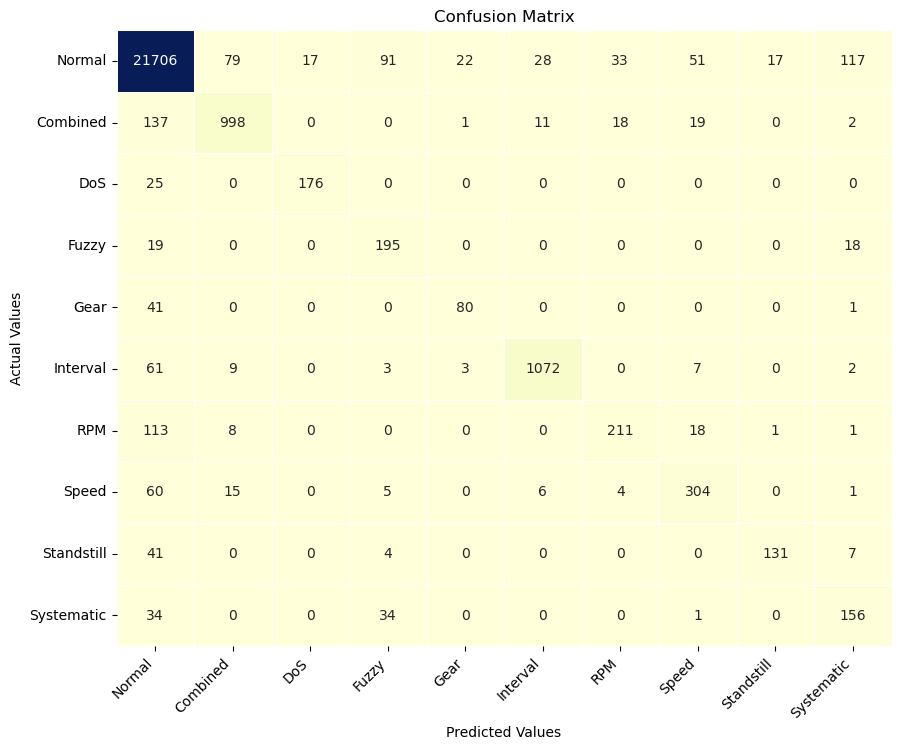

In [21]:
draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_ViT_can_ml_{}.png')